<a href="https://colab.research.google.com/github/RudraPramanik/applied-reinforcement-learning/blob/master/supply-chain-rl/Reinforcement_Learning_Multi_Echelon_Supply_Chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  A Reinforcement Learning Approach to Multi-Echelon Supply Chain Optimization

This notebook presents a research-oriented prototype for **multi-echelon supply chain optimization** using **deep reinforcement learning (DRL)**. The objective is to study how learning-based control policies compare against classical inventory heuristics when operating under **uncertainty, lead times, and cost trade-offs**.

Rather than assuming perfect demand knowledge or static rules, this work frames supply chain decision-making as a **sequential optimization problem**, where actions taken today affect costs and service levels in the future.

---

## Problem Setting

We consider a **multi-echelon supply chain** consisting of:

- One **central factory**
- Multiple **downstream warehouses**
- End customers generating **stochastic, time-varying demand**

The supply chain operates over a finite planning horizon and is subject to several real-world complexities:

- Uncertain customer demand (seasonal / stochastic)
- Production and transportation **lead times**
- Inventory holding costs at each echelon
- Transportation costs between echelons
- Capacity constraints
- Penalties for unmet demand (stock-outs / backlog)

The system must continuously decide:
- How much to **produce at the factory**
- How much to **ship to each warehouse**

while balancing service level and operational cost.

---

##  Prototype Approach

This prototype follows a structured experimental methodology:

1. A **custom simulation environment** is developed to model a realistic multi-echelon supply chain.
2. A classical **(s, Q) inventory policy** is implemented as a strong baseline.
3. A **deep reinforcement learning agent (PPO)** is trained to control production and shipment decisions.
4. The RL policy is evaluated and compared against the baseline under identical conditions.


---

##  Scope and Limitations

The reinforcement learning solution presented here is intended primarily for:

- Research experimentation
- Educational demonstration
- Methodological comparison

While RL offers modeling flexibility, it also introduces:
- High computational cost
- Sensitivity to reward scaling
- Training instability without constraints

##References
- Kemmer, L., et al. Reinforcement Learning for Supply Chain Optimization.
- Sutton & Barto, Reinforcement Learning: An Introduction
- Schulman et al., Proximal Policy Optimization Algorithms

In [3]:
# Installation and Setup

!pip install gymnasium -q
!pip install stable-baselines3 -q
!pip install shimmy -q
!pip install matplotlib seaborn -q

print("✓ All packages installed successfully!")
print("\nPackage versions:")
import gymnasium
import stable_baselines3
print(f"Gymnasium: {gymnasium.__version__}")
print(f"Stable-Baselines3: {stable_baselines3.__version__}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 14.2 MB/s eta 0:00:00
✓ All packages installed successfully!

Package versions:
Gymnasium: 1.2.2
Stable-Baselines3: 2.7.1


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


**Core Imports and Utility Functions**

In [4]:
# Import Required Libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from gymnasium import spaces
import collections
from typing import Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

# Stable-Baselines3 imports
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

# Set random seeds for reproducibility
np.random.seed(42)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


**State and Action Space Definition**

In [5]:
# State and Action Classes

class State:
    """Represents the state of the supply chain at a given time step"""
    def __init__(self, warehouse_num: int, T: int, demand_history: List, t: int = 0):
        self.warehouse_num = warehouse_num
        self.factory_stock = 0
        self.warehouse_stock = np.zeros(warehouse_num)
        self.demand_history = demand_history
        self.T = T
        self.t = t

    def to_array(self) -> np.ndarray:
        """Convert state to numpy array for neural network input"""
        return np.concatenate([
            [self.factory_stock],
            self.warehouse_stock,
            np.hstack(self.demand_history),
            [self.t]
        ])

    def stock_levels(self) -> np.ndarray:
        """Get current stock levels at factory and warehouses"""
        return np.concatenate([[self.factory_stock], self.warehouse_stock])


class Action:
    """Represents production and shipping decisions"""
    def __init__(self, warehouse_num: int):
        self.production_level = 0
        self.shippings_to_warehouses = np.zeros(warehouse_num)

    def __repr__(self):
        return f"Action(production={self.production_level:.1f}, shipments={self.shippings_to_warehouses})"

print("✓ State and Action classes defined!")

✓ State and Action classes defined!


**Multi-Echelon Supply Chain Environment (Gymnasium)**

In [6]:
# Cell 4: Supply Chain Environment (Gymnasium Compatible)

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import collections
from typing import Optional, Tuple

# Assuming State and Action classes are defined somewhere above

class SupplyChainEnv(gym.Env):
    """
    Custom Gymnasium Environment for Supply Chain Management

    Key Modifiable Parameters:
    - lead_times: Delivery delays for factory and warehouses
    - demand_pattern: 'poisson', 'normal', or 'seasonal'
    - storage_costs: Cost per unit stored
    - transportation_costs: Cost per unit shipped
    """

    metadata = {'render_modes': ['human']}

    def __init__(self, config: Optional[dict] = None):
        super().__init__()

        # Default configuration
        self.config = config or {}

        # Episode parameters
        self.T = self.config.get('episode_length', 52)  # 52 weeks (1 year)
        self.warehouse_num = self.config.get('warehouse_num', 3)

        # Demand parameters
        self.demand_pattern = self.config.get('demand_pattern', 'seasonal')
        self.d_max = self.config.get('max_demand', 10)
        self.d_var = self.config.get('demand_variance', 3)

        # Lead times
        self.factory_lead_time = self.config.get('factory_lead_time', 2)
        self.warehouse_lead_times = self.config.get('warehouse_lead_times', [1, 1, 2])

        # Economic parameters
        self.unit_price = self.config.get('unit_price', 100)
        self.unit_cost = self.config.get('unit_cost', 40)

        # Storage capacities
        self.storage_capacities = np.array([30, 20, 30, 40])  # Factory, WH1, WH2, WH3

        # Costs
        self.storage_costs = self.config.get('storage_costs', np.array([2, 3, 4, 5]))
        self.transportation_costs = self.config.get('transportation_costs', np.array([5, 7, 10]))
        self.backlog_penalty = self.config.get('backlog_penalty', self.unit_price)

        # Demand history
        self.demand_history_len = 4
        self.reset()

        # Action space: [production_level, shipment_to_wh1, shipment_to_wh2, shipment_to_wh3]
        self.action_space = spaces.Box(
            low=0.0,
            high=20.0,
            shape=(self.warehouse_num + 1,),
            dtype=np.float32
        )

        # Observation space
        obs_dim = (self.warehouse_num + 1) + (self.warehouse_num * self.demand_history_len) + 1
        self.observation_space = spaces.Box(
            low=-1000,
            high=1000,
            shape=(obs_dim,),
            dtype=np.float32
        )

    def _generate_demand(self, warehouse_id: int, t: int) -> float:
        """Generate demand based on selected pattern"""
        if self.demand_pattern == 'seasonal':
            base_demand = self.d_max/2 + self.d_max/2 * np.sin(
                2 * np.pi * (t + 2 * warehouse_id) / self.T * 2
            )
            demand = base_demand + np.random.randint(-self.d_var, self.d_var + 1)
        elif self.demand_pattern == 'poisson':
            demand = np.random.poisson(lam=self.d_max/2)
        elif self.demand_pattern == 'normal':
            demand = np.random.normal(loc=self.d_max/2, scale=self.d_var)
        return max(0, np.round(demand))

    def reset(self, seed=None, options=None):
        """Reset the environment to initial state"""
        super().reset(seed=seed)

        self.demand_history = collections.deque(maxlen=self.demand_history_len)
        for _ in range(self.demand_history_len):
            self.demand_history.append(np.zeros(self.warehouse_num))

        self.t = 0
        self.state = State(self.warehouse_num, self.T, list(self.demand_history))

        # Initialize pending orders (for lead times)
        self.pending_production = collections.deque(maxlen=self.factory_lead_time)
        self.pending_shipments = [
            collections.deque(maxlen=lt) for lt in self.warehouse_lead_times
        ]

        for _ in range(self.factory_lead_time):
            self.pending_production.append(0)
        for i in range(self.warehouse_num):
            for _ in range(self.warehouse_lead_times[i]):
                self.pending_shipments[i].append(0)

        return self.state.to_array(), {}

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, dict]:
        """Execute one time step"""
        action_obj = Action(self.warehouse_num)
        action_obj.production_level = np.clip(action[0], 0, 20)
        action_obj.shippings_to_warehouses = np.clip(action[1:], 0, 20)

        demands = np.array([
            self._generate_demand(j, self.t) for j in range(self.warehouse_num)
        ])

        # Process lead times
        self.pending_production.append(action_obj.production_level)
        arriving_production = self.pending_production[0] if len(self.pending_production) > 0 else 0

        arriving_shipments = np.zeros(self.warehouse_num)
        for i in range(self.warehouse_num):
            self.pending_shipments[i].append(action_obj.shippings_to_warehouses[i])
            arriving_shipments[i] = self.pending_shipments[i][0] if len(self.pending_shipments[i]) > 0 else 0

        # Reward calculation
        satisfied_demand = np.minimum(self.state.warehouse_stock + arriving_shipments, demands)
        total_revenue = self.unit_price * np.sum(satisfied_demand)
        total_production_cost = self.unit_cost * action_obj.production_level
        current_stocks = np.maximum(self.state.stock_levels(), 0)
        total_storage_cost = np.dot(self.storage_costs, current_stocks)
        stockouts = demands - satisfied_demand
        total_backlog_penalty = self.backlog_penalty * np.sum(stockouts)
        total_transportation_cost = np.dot(self.transportation_costs, action_obj.shippings_to_warehouses)
        reward = (total_revenue - total_production_cost - total_storage_cost - total_backlog_penalty - total_transportation_cost)

        # Update state (🟢 UPDATED: demand_history passed)
        next_state = State(self.warehouse_num, self.T, list(self.demand_history), t=self.t + 1)
        next_state.factory_stock = min(self.state.factory_stock + arriving_production - np.sum(action_obj.shippings_to_warehouses),
                                       self.storage_capacities[0])
        for w in range(self.warehouse_num):
            next_state.warehouse_stock[w] = min(self.state.warehouse_stock[w] + arriving_shipments[w] - demands[w],
                                                self.storage_capacities[w + 1])

        self.demand_history.append(demands)
        next_state.demand_history = list(self.demand_history)

        self.state = next_state
        self.t += 1

        terminated = self.t >= self.T
        truncated = False

        info = {
            'demands': demands,
            'satisfied_demand': satisfied_demand,
            'stockouts': stockouts,
            'total_revenue': total_revenue,
            'total_cost': total_production_cost + total_storage_cost + total_backlog_penalty + total_transportation_cost
        }

        return self.state.to_array(), reward, terminated, truncated, info

print("✓ Supply Chain Environment created!")
print("\n📋 Modifiable Parameters:")
print("   - demand_pattern: 'seasonal', 'poisson', 'normal'")
print("   - factory_lead_time: Delivery delay from production")
print("   - warehouse_lead_times: Delivery delays to warehouses")
print("   - storage_costs: Cost per unit stored")
print("   - transportation_costs: Cost per unit shipped")
print("   - backlog_penalty: Penalty for stockouts")


✓ Supply Chain Environment created!

📋 Modifiable Parameters:
   - demand_pattern: 'seasonal', 'poisson', 'normal'
   - factory_lead_time: Delivery delay from production
   - warehouse_lead_times: Delivery delays to warehouses
   - storage_costs: Cost per unit stored
   - transportation_costs: Cost per unit shipped
   - backlog_penalty: Penalty for stockouts


In [7]:
# Cell 5: Test the Environment

# Create environment with default settings
env = SupplyChainEnv()

# Test reset
obs, info = env.reset()
print(f"✓ Environment reset successful")
print(f"Observation shape: {obs.shape}")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

# Test few random steps
print("\n🔄 Testing random actions:")
for i in range(3):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"  Step {i+1}: Reward = {reward:.2f}, Demands = {info['demands']}")

print("\n✓ Environment is working correctly!")

✓ Environment reset successful
Observation shape: (17,)
Action space: Box(0.0, 20.0, (4,), float32)
Observation space: Box(-1000.0, 1000.0, (17,), float32)

🔄 Testing random actions:
  Step 1: Reward = -202.09, Demands = [ 8.  7. 10.]
  Step 2: Reward = 382.98, Demands = [ 9.  7. 11.]
  Step 3: Reward = 1489.38, Demands = [ 8. 12.  8.]

✓ Environment is working correctly!


In [8]:
# Visualization Functions

def visualize_demand_patterns(env, steps=52):
    """Visualize demand patterns for all warehouses"""
    demands = np.zeros((env.warehouse_num, steps))

    for t in range(steps):
        for w in range(env.warehouse_num):
            demands[w, t] = env._generate_demand(w, t)

    plt.figure(figsize=(14, 5))
    for w in range(env.warehouse_num):
        plt.plot(range(steps), demands[w], marker='o', label=f'Warehouse {w+1}', alpha=0.7)

    plt.xlabel('Time Step (weeks)', fontsize=12)
    plt.ylabel('Demand (units)', fontsize=12)
    plt.title(f'Demand Pattern: {env.demand_pattern.upper()}', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def visualize_episode(env, policy=None, policy_name="Policy"):
    """
    Run and visualize one complete episode

    Args:
        env: Supply chain environment
        policy: Agent/policy to test (if No, uses random actions)
        policy_name: Name for the plot title
    """
    obs, _ = env.reset()

    # Storage for metrics
    factory_stocks = []
    warehouse_stocks = [[] for _ in range(env.warehouse_num)]
    productions = []
    shipments = [[] for _ in range(env.warehouse_num)]
    rewards = []
    demands = [[] for _ in range(env.warehouse_num)]

    terminated = False
    step = 0

    while not terminated and step < env.T:
        # Get action
        if policy is None:
            action = env.action_space.sample()
        else:
            action, _ = policy.predict(obs, deterministic=True)

        # Store current state
        factory_stocks.append(env.state.factory_stock)
        for w in range(env.warehouse_num):
            warehouse_stocks[w].append(env.state.warehouse_stock[w])
        productions.append(action[0])
        for w in range(env.warehouse_num):
            shipments[w].append(action[w + 1])

        # Take step
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        for w in range(env.warehouse_num):
            demands[w].append(info['demands'][w])

        step += 1

    # Create comprehensive visualization
    fig, axes = plt.subplots(5, 1, figsize=(14, 12))
    time_steps = range(len(rewards))

    # 1. Factory Stock
    axes[0].plot(time_steps, factory_stocks, color='purple', linewidth=2, label='Factory Stock')
    axes[0].axhline(y=env.storage_capacities[0], color='r', linestyle='--', alpha=0.5, label='Capacity')
    axes[0].set_ylabel('Units', fontsize=10)
    axes[0].set_title('Factory Inventory', fontsize=11, fontweight='bold')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)

    # 2. Warehouse Stocks
    for w in range(env.warehouse_num):
        axes[1].plot(time_steps, warehouse_stocks[w], linewidth=2,
                    label=f'Warehouse {w+1}', alpha=0.7)
    axes[1].set_ylabel('Units', fontsize=10)
    axes[1].set_title('Warehouse Inventories', fontsize=11, fontweight='bold')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    # 3. Production
    axes[2].bar(time_steps, productions, color='blue', alpha=0.6)
    axes[2].set_ylabel('Units', fontsize=10)
    axes[2].set_title('Production Decisions', fontsize=11, fontweight='bold')
    axes[2].grid(True, alpha=0.3)

    # 4. Shipments vs Demands
    x = np.arange(len(time_steps))
    width = 0.2
    for w in range(env.warehouse_num):
        axes[3].bar(x + w*width, shipments[w], width, label=f'Ship to WH{w+1}', alpha=0.6)
        axes[3].plot(time_steps, demands[w], marker='x', linestyle='--',
                    label=f'Demand WH{w+1}', alpha=0.7)
    axes[3].set_ylabel('Units', fontsize=10)
    axes[3].set_title('Shipments vs Demands', fontsize=11, fontweight='bold')
    axes[3].legend(loc='upper right', fontsize=8, ncol=2)
    axes[3].grid(True, alpha=0.3)

    # 5. Rewards
    axes[4].plot(time_steps, rewards, color='green', linewidth=2, label='Step Reward')
    axes[4].plot(time_steps, np.cumsum(rewards), color='darkgreen',
                linewidth=2, linestyle='--', label='Cumulative Reward')
    axes[4].set_xlabel('Time Step (weeks)', fontsize=11)
    axes[4].set_ylabel('Reward ($)', fontsize=10)
    axes[4].set_title('Rewards', fontsize=11, fontweight='bold')
    axes[4].legend(loc='lower right')
    axes[4].grid(True, alpha=0.3)

    plt.suptitle(f'{policy_name} Performance | Total Reward: ${sum(rewards):.2f}',
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\n📊 Episode Summary ({policy_name}):")
    print(f"   Total Reward: ${sum(rewards):.2f}")
    print(f"   Average Reward per Step: ${np.mean(rewards):.2f}")
    print(f"   Average Factory Stock: {np.mean(factory_stocks):.1f} units")
    print(f"   Average Production: {np.mean(productions):.1f} units/week")

    return sum(rewards)

print("✓ Visualization functions ready!")

✓ Visualization functions ready!


**Baseline Inventory Control Policy (s, Q)**

In [9]:
# Baseline (s, Q) Policy

class SQPolicy:
    """
    (s, Q) Reorder Policy - Baseline for comparison

    Logic: When inventory falls below 's' (reorder point), order 'Q' units
    """
    def __init__(self, factory_s, factory_Q, warehouse_s, warehouse_Q):
        self.factory_s = factory_s
        self.factory_Q = factory_Q
        self.warehouse_s = warehouse_s  # List of reorder points
        self.warehouse_Q = warehouse_Q  # List of reorder quantities

    def predict(self, obs, deterministic=True):
        """Make prediction (compatible with RL interface)"""
        # Extract state from observation
        warehouse_num = len(self.warehouse_s)
        factory_stock = obs[0]
        warehouse_stocks = obs[1:warehouse_num + 1]

        action = np.zeros(warehouse_num + 1)

        # Reorder for warehouses if below safety stock
        for w in range(warehouse_num):
            if warehouse_stocks[w] < self.warehouse_s[w]:
                action[w + 1] = self.warehouse_Q[w]

        # Produce if factory stock will fall below safety level
        total_shipments = np.sum(action[1:])
        if factory_stock - total_shipments < self.factory_s:
            action[0] = self.factory_Q

        return action, None

# baseline policy with hand-tuned parameters
baseline_policy = SQPolicy(
    factory_s=5,
    factory_Q=15,
    warehouse_s=[3, 3, 5],
    warehouse_Q=[8, 8, 10]
)

print("✓ Baseline (s,Q) Policy created!")
print(f"   Factory: Reorder {baseline_policy.factory_Q} units when stock < {baseline_policy.factory_s}")
print(f"   Warehouses: Reorder points = {baseline_policy.warehouse_s}")
print(f"   Warehouses: Reorder quantities = {baseline_policy.warehouse_Q}")

✓ Baseline (s,Q) Policy created!
   Factory: Reorder 15 units when stock < 5
   Warehouses: Reorder points = [3, 3, 5]
   Warehouses: Reorder quantities = [8, 8, 10]


**Environment Rollout and Visualization Utilities**

🔍 Testing with SEASONAL demand pattern:


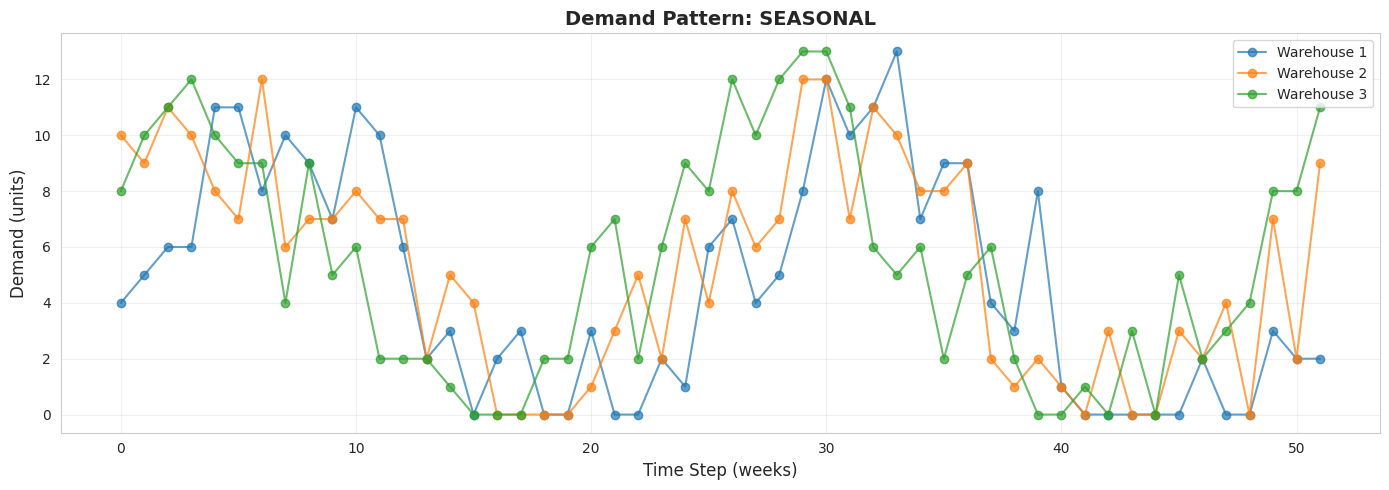


🎯 Testing Baseline (s,Q) Policy:


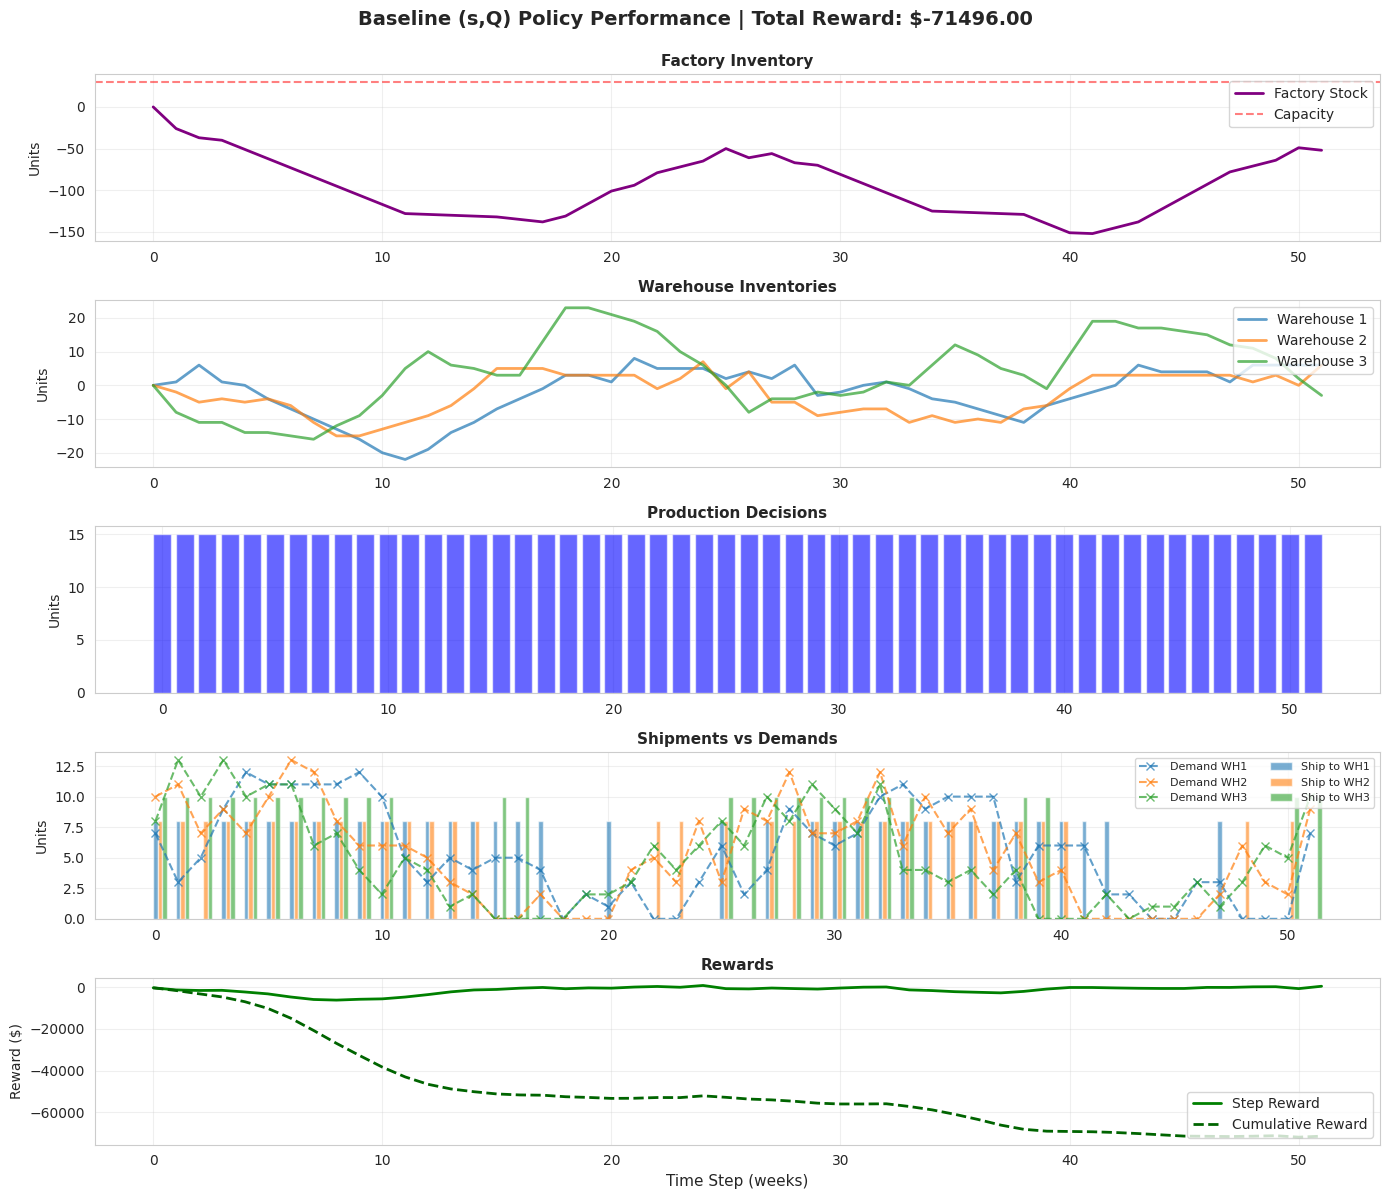


📊 Episode Summary (Baseline (s,Q) Policy):
   Total Reward: $-71496.00
   Average Reward per Step: $-1374.92
   Average Factory Stock: -95.5 units
   Average Production: 15.0 units/week


In [10]:
#Visualize Demand Patterns and Test Baseline

# Create environment with SEASONAL demand (default)
print("🔍 Testing with SEASONAL demand pattern:")
env_seasonal = SupplyChainEnv(config={'demand_pattern': 'seasonal'})
visualize_demand_patterns(env_seasonal, steps=52)

# Test baseline policy
print("\n🎯 Testing Baseline (s,Q) Policy:")
baseline_reward = visualize_episode(env_seasonal, baseline_policy, "Baseline (s,Q) Policy")

**Reinforcement Learning Algorithm Selection (PPO)**

In [11]:
# Custom Training Callback for Monitoring

class TrainingCallback(BaseCallback):
    """
    Custom callback for monitoring training progress
    """
    def __init__(self, eval_freq=1000, verbose=1):
        super().__init__(verbose)
        self.eval_freq = eval_freq
        self.episode_rewards = []
        self.episode_lengths = []
        self.current_episode_reward = 0
        self.current_episode_length = 0

    def _on_step(self) -> bool:
        # Track episode progress
        self.current_episode_reward += self.locals['rewards']  # <- changed from [0]
        self.current_episode_length += 1

        # Check if episode ended
        if self.locals['dones']:
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_lengths.append(self.current_episode_length)

            if self.verbose > 0 and len(self.episode_rewards) % 10 == 0:
                avg_reward = np.mean(self.episode_rewards[-10:])
                print(f"Episode {len(self.episode_rewards)}: Avg Reward (last 10) = ${avg_reward:.2f}")

            self.current_episode_reward = 0
            self.current_episode_length = 0

        return True

    def plot_training_progress(self):
        """Plot training progress"""
        if len(self.episode_rewards) == 0:
            print("No episodes completed yet!")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

        # Plot rewards
        ax1.plot(self.episode_rewards, alpha=0.3, color='blue')

        # Moving average
        window = min(20, len(self.episode_rewards))
        if window > 1:
            moving_avg = np.convolve(self.episode_rewards,
                                    np.ones(window)/window, mode='valid')
            ax1.plot(range(window-1, len(self.episode_rewards)),
                    moving_avg, color='red', linewidth=2, label=f'{window}-Episode Moving Avg')

        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward ($)')
        ax1.set_title('Training Progress: Episode Rewards')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot episode lengths
        ax2.plot(self.episode_lengths, alpha=0.6, color='green')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Episode Length')
        ax2.set_title('Episode Lengths')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"\n📈 Training Statistics:")
        print(f"   Total Episodes: {len(self.episode_rewards)}")
        print(f"   Best Reward: ${max(self.episode_rewards):.2f}")
        print(f"   Average Reward (last 20): ${np.mean(self.episode_rewards[-20:]):.2f}")

print("✓ Training callback ready!")

✓ Training callback ready!


**PPO Agent Training**

In [13]:
# Train PPO Agent (Continuous Action Space)

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

print("🤖 Training PPO Agent...")
print("This will take a few minutes...")

# Create training environment
env_train = SupplyChainEnv(config={
    'demand_pattern': 'seasonal',
    'episode_length': 52,
    'factory_lead_time': 2,
    'warehouse_lead_times': [1, 1, 2],
    'storage_costs': np.array([2, 3, 4, 5]),
    'transportation_costs': np.array([5, 7, 10]),
    'backlog_penalty': 100
})

env_train = Monitor(env_train)

# PPO model (continuous actions ✔)
ppo_model = PPO(
    policy="MlpPolicy",
    env=env_train,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.95,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    policy_kwargs=dict(
        net_arch=dict(pi=[256, 256], vf=[256, 256])
    ),
    verbose=1
)

# Train
ppo_model.learn(
    total_timesteps=52 * 100,  # 100 episodes
    progress_bar=True
)

print("✅ PPO Training Complete!")


🤖 Training PPO Agent...
This will take a few minutes...
Using cuda device
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 52       |
|    ep_rew_mean     | -4.4e+06 |
| time/              |          |
|    fps             | 559      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52            |
|    ep_rew_mean          | -4.42e+06     |
| time/                   |               |
|    fps                  | 453           |
|    iterations           | 2             |
|    time_elapsed         | 9             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.5632249e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | 1.19e-07      |


✅ PPO Training Complete!


**PPO Policy Evaluation**

🎯 Evaluating PPO Agent...


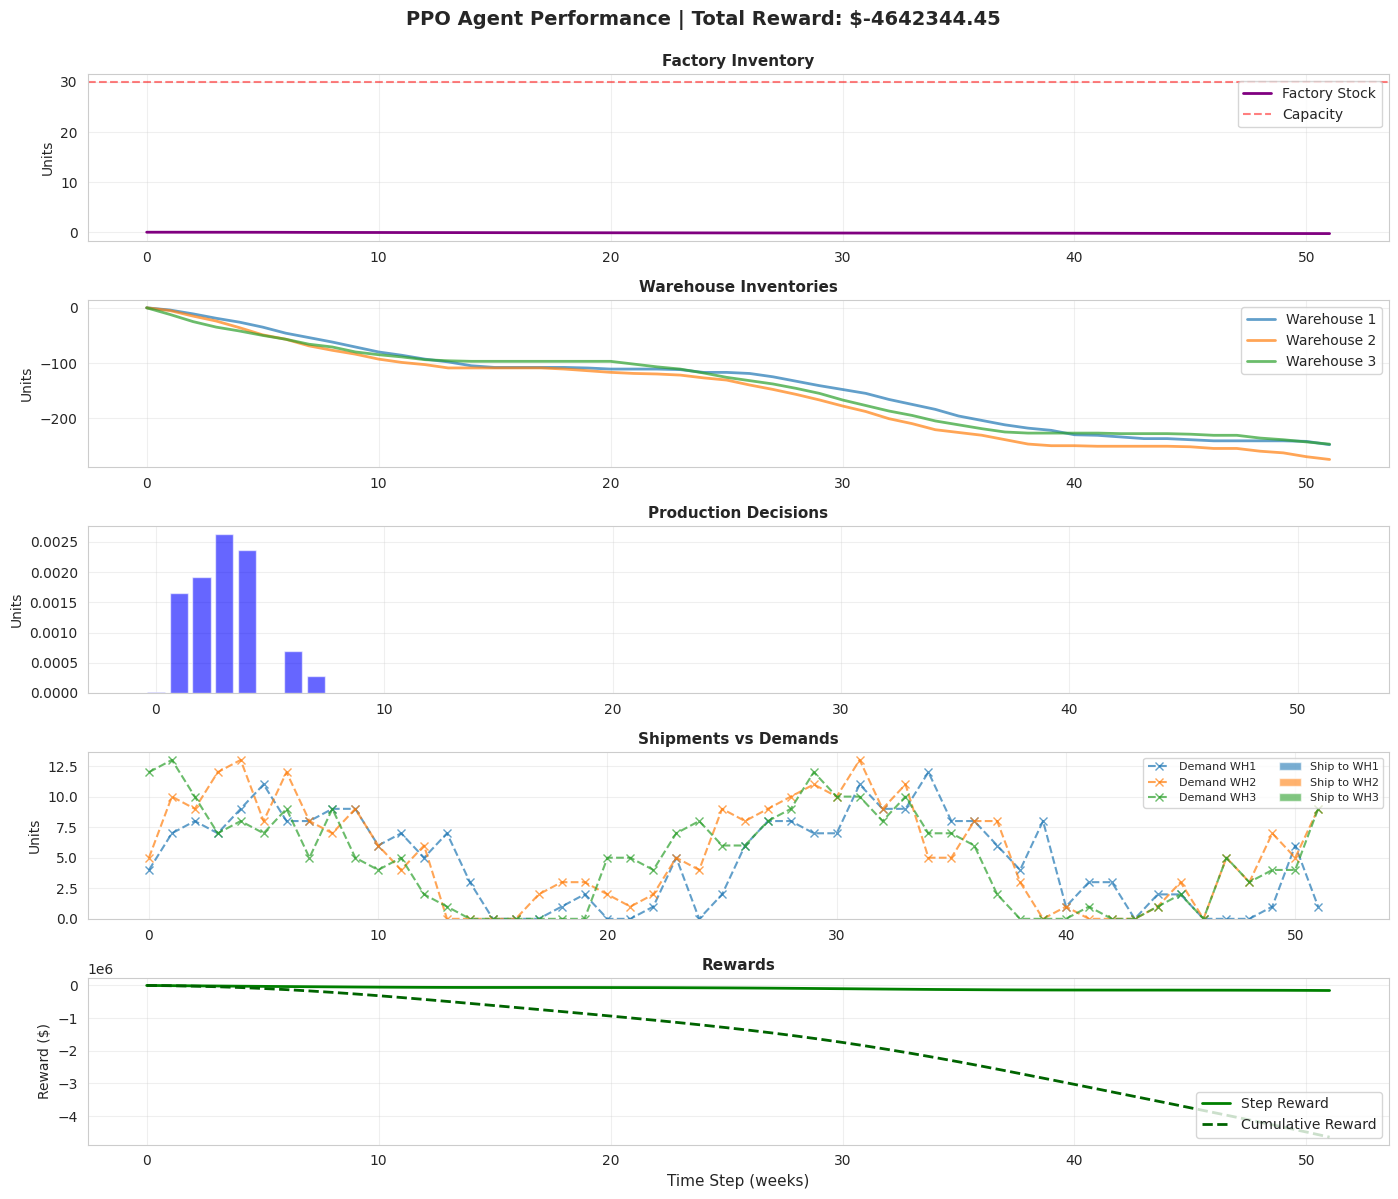


📊 Episode Summary (PPO Agent):
   Total Reward: $-4642344.45
   Average Reward per Step: $-89275.85
   Average Factory Stock: -0.1 units
   Average Production: 0.0 units/week
✅ PPO Total Reward: $-4642344.45


In [22]:
# Evaluate PPO Agent

print("🎯 Evaluating PPO Agent...")

env_eval = SupplyChainEnv(config={
    'demand_pattern': 'seasonal',
    'episode_length': 52,
    'factory_lead_time': 2,
    'warehouse_lead_times': [1, 1, 2],
    'storage_costs': np.array([2, 3, 4, 5]),
    'transportation_costs': np.array([5, 7, 10]),
    'backlog_penalty': 100
})

#pass PPO model positionally (not as keyword)
ppo_reward = visualize_episode(
    env_eval,
    ppo_model,
    "PPO Agent"
)

print(f"✅ PPO Total Reward: ${ppo_reward:.2f}")


**Performance Comparison and Cost Analysis**

In [23]:
# Performance Comparison

print("\n📊 Performance Comparison:")
print(f"   Baseline (s,Q) Policy: ${baseline_reward:.2f}")
print(f"   PPO Agent:             ${ppo_reward:.2f}")

improvement = ppo_reward - baseline_reward
percent_improvement = (improvement / abs(baseline_reward)) * 100

print(f"   Improvement:           ${improvement:.2f} ({percent_improvement:.1f}%)")



📊 Performance Comparison:
   Baseline (s,Q) Policy: $-71496.00
   PPO Agent:             $-4642344.45
   Improvement:           $-4570848.45 (-6393.2%)


In [25]:
# Performance Comparison

print("\n🏆 Final Performance Comparison")
print(f"Baseline Policy Reward: ${baseline_reward:.2f}")
print(f"PPO Agent Reward:       ${ppo_reward:.2f}")

if ppo_reward > baseline_reward:
    print("✅ PPO Agent outperforms Baseline Policy")
else:
    print("⚠ Baseline Policy outperforms PPO (consider tuning PPO)")



🏆 Final Performance Comparison
Baseline Policy Reward: $-71496.00
PPO Agent Reward:       $-4642344.45
⚠ Baseline Policy outperforms PPO (consider tuning PPO)


In [27]:
def visualize_episode(env, agent=None, title="", return_rewards=False):
    obs, _ = env.reset()
    done = False

    rewards = []
    stocks = []
    demands = []

    while not done:
        if agent is None:
            # Baseline (s, Q) policy
            action = np.array([10, 5, 5, 5], dtype=np.float32)
        else:
            action, _ = agent.predict(obs, deterministic=True)

        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        rewards.append(reward)
        stocks.append(env.state.stock_levels())
        demands.append(info["demands"])

    rewards = np.array(rewards)

    if return_rewards:
        return rewards

    # Visualization
    stocks = np.array(stocks)
    demands = np.array(demands)

    plt.figure(figsize=(12, 5))
    for i in range(stocks.shape[1]):
        plt.plot(stocks[:, i], label=f"Stock {i}")
    plt.title(title)
    plt.xlabel("Week")
    plt.ylabel("Inventory Level")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    total_reward = rewards.sum()
    return total_reward


📌 Visualization saved as policy_comparison.png


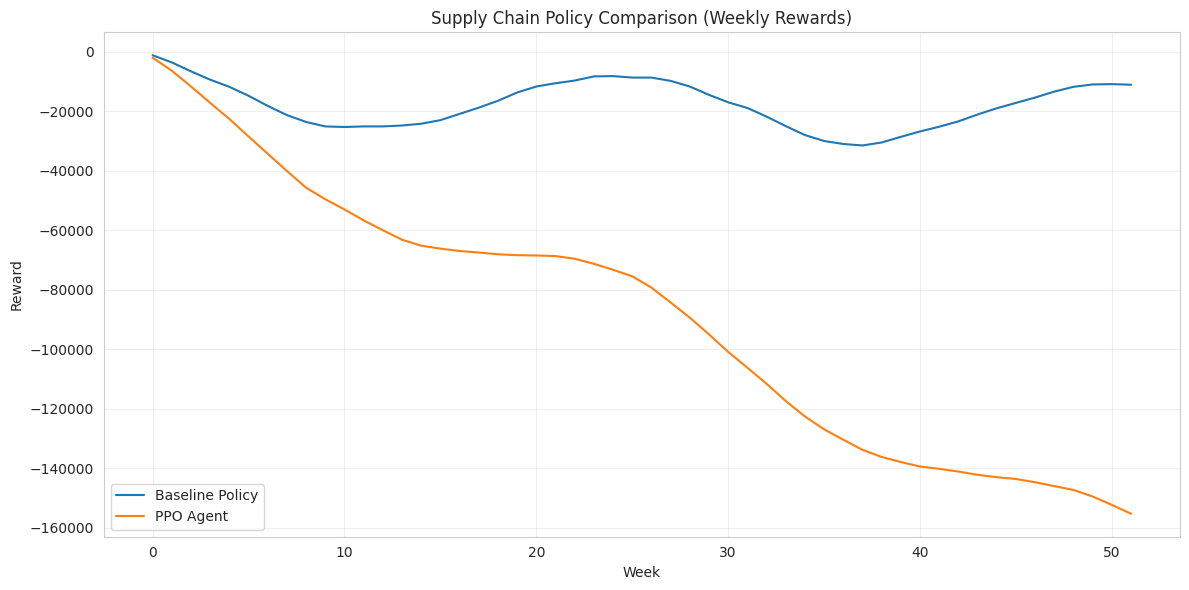

In [28]:
# Visual Comparison & Save Plot

import matplotlib.pyplot as plt

def visualize_comparison(env, ppo_model, save_path="policy_comparison.png"):
    baseline_rewards = visualize_episode(env, None, return_rewards=True)
    ppo_rewards = visualize_episode(env, ppo_model, return_rewards=True)

    plt.figure(figsize=(12, 6))
    plt.plot(baseline_rewards, label="Baseline Policy")
    plt.plot(ppo_rewards, label="PPO Agent")

    plt.title("Supply Chain Policy Comparison (Weekly Rewards)")
    plt.xlabel("Week")
    plt.ylabel("Reward")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)

    print(f"📌 Visualization saved as {save_path}")
    plt.show()

env_compare = SupplyChainEnv(config={
    'demand_pattern': 'seasonal',
    'episode_length': 52
})

visualize_comparison(env_compare, ppo_model)
